# Inversion d'Occam

Avec cet exemple, on va examiner comment l'inversion d'Occam peut être utile pour estimer la distribution verticale de la conductivité électrique de la proche surface.  Les mesures utilisées ont été acquises avec un conductivimètre à induction EM38 de la compagnie Geonics, illustré ci-dessous.  Cette appareil est constitué d'une bobine émettrice et d'une bobine réceptrice, séparées d'un mètre.

![alt text](EM38.jpg)

En effectuant les mesures à des hauteurs croissantes, on se trouve à accroître le volume de sol investigué et ainsi accroître la profondeur d'investigation.  Par ailleurs, on change également la profondeur d'investigation en changeant l'orientation des bobines, une polarisation horizontale étant plus sensible aux horizons superficiels.  Le levé consiste ainsi en 18 mesures, acquises à 9 hauteurs différentes pour des bobines orientées verticalement et horizontalement.  

| Hauteur (cm) | EMV (mS/m) | EMH (mS/m) |
|--------------|------------|------------|
|        0     |   134.5    |   117.4    |
|       10     |   129.0    |    97.7    |
|       20     |   120.5    |    81.7    |
|       30     |   110.5    |    69.2    |
|       40     |   100.5    |    59.6    |
|       50     |    90.8    |    51.8    |
|       75     |    70.9    |    38.2    |
|      100     |    56.8    |    29.8    |
|      150     |    38.5    |    19.9    |

La modélisation de la réponse du EM38 est assez compliquée, et des expressions analytiques ne sont pas disponibles pour calculer la jacobienne.  

Le module ```em``` contient deux classes permettant de calcul la réponse pour un sol stratifié.  Une méthode pour calculer la jacobienne par différences finies est aussi incluse.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from geo1302.em import EM38, Ground

help(Ground)
help(EM38)

Help on class Ground in module geo1302.em:

class Ground(builtins.object)
 |  Ground(nlayer=11, d=0.2)
 |  
 |  Classe pour décrire un sol stratifié
 |  
 |  Paramètres
 |  ----------
 |  nlayer : int
 |      nombre de couches
 |  d : float
 |      épaisseur des couches
 |  
 |  Methods defined here:
 |  
 |  __init__(self, nlayer=11, d=0.2)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  plot(self, sigma, ax=None)
 |      Trace la conductivité en fct de la profondeur
 |      
 |      Paramètres
 |      ----------
 |      sigma : array numpy
 |          conductivité des couches en S/m
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

Help on class EM38 in module geo1302.em:

class EM38(builtins.object)
 |  EM38(h, ground, f=14600.0, r=1.0)

On créé d'abord un modèle de sol comportant 11 couches de 20 cm chacune (paramètres par défaut de la classe ```Ground```).  On défini ensuite un vecteur contenant les hauteurs de mesure pour pouvoir initialiser un object ```EM38```.

In [2]:
hauteurs = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.50])

sol = Ground()
em38 = EM38(hauteurs, sol)

La conductivité du modèle est représentative d'un sol sec en surface (conductivité faible), suivi d'une zone vadoze où la conductivité augmente graduellement.

On peut maintenant générer des données, auxquelles on ajoute un bruit gaussien.

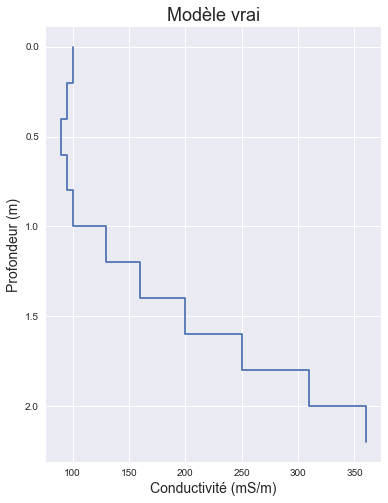

In [3]:
mtrue = np.array([100, 95, 90, 95, 100, 130, 160, 200, 250, 310, 360])/1000.0

datanf = em38.G(mtrue)
data = datanf + 0.1*np.random.randn(datanf.size)

sol.plot(mtrue)
plt.title('Modèle vrai', fontsize=18)
plt.show()

Examinons d'abord la solution obtenue avec la méthode de Marquardt-Levenberg, qui ne comporte pas de terme de régularisation.

In [4]:
def lm(G, jac, d, m0, maxit=100, eps=1.e-8):
    m = m0.copy()
    kr = eps
    iteration = 1
    maxiteration = maxit
    dfit = 1

    while iteration < maxiteration:
        Gm = G(m)

        e1 = d - Gm
        e1 = e1.reshape(-1, 1)
        misfit1 = e1.T.dot(e1)
        if misfit1 < kr:
            return m
        J = jac(m)
        U, s, Vh = np.linalg.svd(J, full_matrices=False)
        V = Vh.T
        l = 0
        k = 1
        S = np.eye(s.size)
        while l < s.size:
            beta = s[l] * dfit**(1.0/(l+1))
            if beta < 1.e-5:
                beta = 0.001*(l+1)
            for i4 in np.arange(s.size):
                S[i4, i4] = s[i4] / (s[i4]*s[i4] + beta*beta)
            dmg = V @ S @ U.T @ e1
            mg = m + dmg.flatten()
            Gm = G(mg)
            e2 = d - Gm
            misfit2 = e2.T.dot(e2)
            if misfit2 > misfit1:
                l += 1
                k += 1
                if k == s.size:
                    return m
            else:
                l = s.size+1
                m = mg
                dfit = (misfit1-misfit2)/misfit1
                iteration += 1
                if dfit < kr:
                    return m
    return m


m0 = 200.0/1000.0 + np.zeros(mtrue.shape)

import time

t0 = time.time()
mlm = lm(em38.G, em38.jac, data, m0, 50, 1.e-6)
t_lm = time.time() - t0

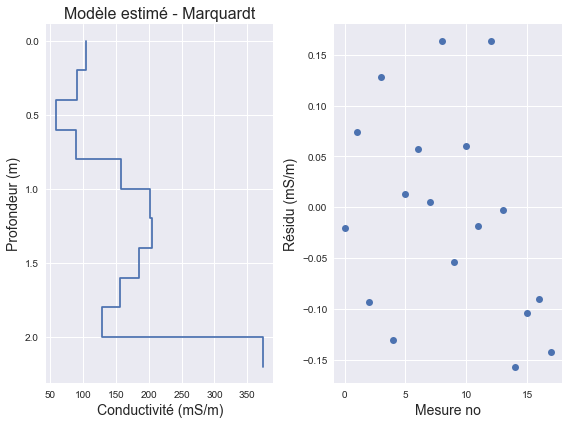

In [5]:
plt.figure(figsize=(8,6))
ax1 = plt.subplot(121)
sol.plot(mlm, ax1)
plt.title('Modèle estimé - Marquardt', fontsize=16)
plt.subplot(122)
plt.plot(em38.G(mlm)-data, 'o')
plt.xlabel('Mesure no', fontsize=14)
plt.ylabel('Résidu (mS/m)', fontsize=14)
plt.tight_layout()
plt.show()

On peut remarquer des variations brusques dans le modèle, qui ne correspondent pas au résultat attendu.  Voyons maintenant l'inversion d'Occam.

In [6]:
def get_D(n, deg):
    if deg == 0:
        return np.eye(n)
    
    df = np.hstack((np.array([-1, 1]), np.zeros((deg-1,))))
    for i in range(1, deg):
        # take the difference of the lower order derivative and itself shifted left 
        # to get a derivative one order higher
        df = np.hstack((np.zeros((1,)), df[:deg])) - np.hstack((df[:deg], np.zeros((1,))))

    dn  = n - deg
    D = np.zeros((dn, n))
    for d in range(deg+1):
        for i in range(dn):
            j = i+d
            D[i, j] = df[d]
    return D
    

def occam(G, jac, D, d, m0, delta):
    """
    Inversion d'Occam (adapté des codes Matlab de B. Borchers)
    
    Paramètres
    ----------
    G : fonction G(m)
        fonction calculant le modèle direct
    jac : fonction jac(m)
        fonction calculant la jacobienne
    d : array numpy
        données
    m0 : array numpy
        modèle initial
    delta : float
        seuil d'application du principe de divergence (discrepancy)
        
    Retourne
    --------
    m : array numpy
        modèle estimé
    """
    
    m = m0.copy()
    oldm = np.zeros(m.shape)
    it = 0
    
    DTD = D.T.dot(D)
    
    Gm = G(m)
    mchi2 = np.linalg.norm(Gm - d)**2
    
    # recherche "force brute" du alpha optimal
    alphas = np.logspace(-20, 0, 100)
    chis = np.empty((alphas.size,))

    while (np.linalg.norm(oldm-m)/np.linalg.norm(m) > 5.0e-3) or (mchi2 > delta*delta*1.01):
        it += 1
        if it > 30:
            return m
        
        oldm = m.copy()
        
        J = jac(m)
        
        dhat = d - Gm + J.dot(m)
                
        for i in range(alphas.size):
            M = J.T.dot(J) + alphas[i]**2*DTD
            if np.linalg.cond(M) < 1.e15:
                
                m = np.linalg.solve(M, J.T.dot(dhat))
                
                chis[i] = np.linalg.norm(G(m) - d)**2
            else:
                chis[i] = np.inf
                
        y = chis.min()
        if y > delta*delta:
            i = np.argmin(chis)
            alpha = alphas[i]
        else:
            i = np.where(chis<=delta*delta)
            alpha = alphas[np.max(i)]
            
        m = np.linalg.solve(J.T.dot(J) + alpha**2*DTD, J.T.dot(dhat))
        Gm = G(m)
        mchi2 = np.linalg.norm(Gm - d)**2
        
    return m


D = get_D(mtrue.size, 2)
delta = 0.1 * np.sqrt(18)
t0 = time.time()
moccam = occam(em38.G, em38.jac, D, data, m0, delta)
t_occam = time.time() - t0

print(t_lm, t_occam)

245.1153998374939 156.68806791305542


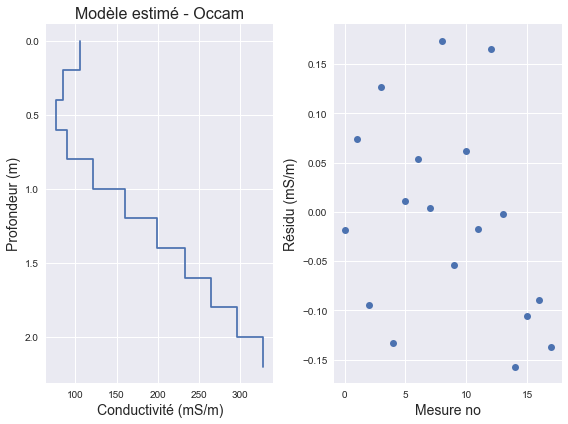

In [7]:
plt.figure(figsize=(8,6))
ax1 = plt.subplot(121)
sol.plot(moccam, ax1)
plt.title('Modèle estimé - Occam', fontsize=16)
plt.subplot(122)
plt.plot(em38.G(moccam)-data, 'o')
plt.xlabel('Mesure no', fontsize=14)
plt.ylabel('Résidu (mS/m)', fontsize=14)
plt.tight_layout()
plt.show()